# Yelp Recommendation System

Imagine that a Yelp user has just finished a glowing review for a Thai restaurant in San Francisco. As they submit their review, they are wondering if there are any other Thai restaurants in the area that are just as good or even better than the restaurant they just review. Our goal in this model is to help recommend 5 different restaurants for this user based on their review of the initial restaurant and other restaurant information.

This module takes reviews for San Francisco restaurants and creates a model that recommends the top 5 restaurants for that reviewer based on the restaurant's food category, star rating, and review sentiment. We utilize a Word2Vec model to analyze the review text and Word Mover's Distance to determine the similarity between two given reviews. We further use TextBlob sentiment analysis to determine the positivity of each review.

In [137]:
# Import Packages
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import word_tokenize
import nltk; nltk.download('stopwords') 
import gensim
import pandas as pd
from pymongo import MongoClient
from pprint import pprint
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import spacy
from textblob import TextBlob
import pyemd
from random import choice
import json
import numpy as np
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeloretizo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Connect to Database

In [62]:
# connect to the local mongodb instance
client = MongoClient('localhost',27017)

# navigate to the correct database and collection
db = client['yelp']
yelp = db.yelp
all_restaurants = pd.DataFrame(yelp.find())

In [63]:
all_restaurants.shape

(3006, 20)

In [64]:
all_restaurants['reviews']

0       [{'reviewRating': {'ratingValue': 5}, 'datePub...
1       [{'reviewRating': {'ratingValue': 5}, 'datePub...
2       [{'reviewRating': {'ratingValue': 4}, 'datePub...
3       [{'reviewRating': {'ratingValue': 4}, 'datePub...
4       [{'reviewRating': {'ratingValue': 4}, 'datePub...
                              ...                        
3001    [{'reviewRating': {'ratingValue': 5}, 'datePub...
3002    [{'reviewRating': {'ratingValue': 4}, 'datePub...
3003    [{'reviewRating': {'ratingValue': 2}, 'datePub...
3004    [{'reviewRating': {'ratingValue': 4}, 'datePub...
3005    [{'reviewRating': {'ratingValue': 4}, 'datePub...
Name: reviews, Length: 3006, dtype: object

## Clean Review Text

In [67]:
# get review descriptions for each restaurant
all_restaurants['review_text'] = all_restaurants['reviews'].apply(lambda x: [r['description'] for r in x])
all_restaurants['review_text'].head()

0    [Pros: \n- excellent service, I tried at least...
1    [The Golden Gate Heights neighborhood, as part...
2    [After a walk along the Great Highway, we were...
3    [I've been looking for a good spot to get my g...
4    [What a gem in the middle of Golden Gate park....
Name: review_text, dtype: object

In [69]:
# tokenize the review text
all_restaurants['review_tokens'] = all_restaurants['review_text'].apply(
    lambda x: [word_tokenize(r) for r in x])

# convert tokens to lower case
all_restaurants['review_tokens'] = all_restaurants['review_tokens'].apply(
    lambda x: [[w.lower() for w in r] for r in x])

# remove punctuation
all_restaurants['review_tokens'] = all_restaurants['review_tokens'].apply(
    lambda x: [[w for w in r if w.isalpha()] for r in x])

In [70]:
# make list of token lists for entire vocabulary
all_reviews = all_restaurants['review_tokens'].sum()

## Create Word2VecModel

In [72]:
# create word2vec model with list of token lists
model = gensim.models.Word2Vec(all_reviews, size=100, window=5, min_count=1)

In [74]:
# check if model was successful (find closest contextual words to "sunset")
word_vectors = model.wv
w1 = 'sunset'
word_vectors.most_similar (positive=w1)

[('richmond', 0.9511774778366089),
 ('castro', 0.8157719373703003),
 ('financial', 0.7968459129333496),
 ('mission', 0.7964378595352173),
 ('portola', 0.7717380523681641),
 ('marina', 0.7526158094406128),
 ('bayview', 0.7440110445022583),
 ('tenderloin', 0.7322458028793335),
 ('dogpatch', 0.7275149822235107),
 ('excelsior', 0.7261304259300232)]

In [140]:
# find word clusters based on a list of initial words
keys = ['food', 'service', 'fun', 'sad', 'location', 'best', 'delivery', 'bad', 'expensive',
        'healthy', 'portions', 'date', 'family', 'group']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [141]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

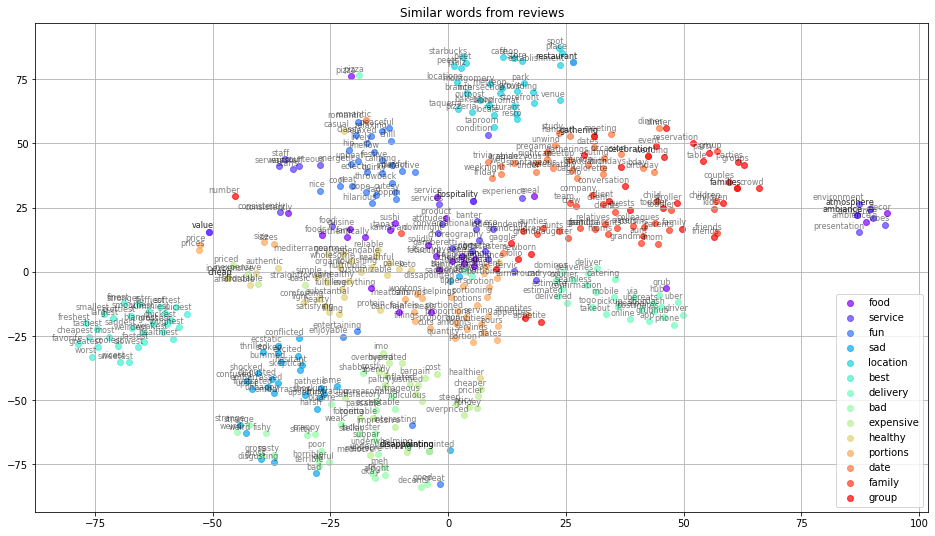

In [142]:
# plot the word clusters
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from reviews', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

## Document Distance + Sentiment Analysis

The idea behind the recommendation feature is that a user can write a new recommendatio for a given restaurant, and based on the review they wrote, we can recommend other restaurants in the same food category that had a similary review to the one written. If the review they are giving is bad, they have the top 5 restaurants they may not want to try next. If the review they are giving is good, they have another restaurant to try

In [139]:
# test how document distance works
model.wmdistance(all_restaurants['review_text'].tolist()[0][1],all_restaurants['review_text'].tolist()[11][2])

1.111725896153972

In [81]:
# transform categories from list of JSON to list
def extract_categories(category_list:list) -> list:
    alias_list = []
    for cat in category_list:
        alias_list.append(cat['alias'])
    return alias_list

In [82]:
# compute the sentiment rating for reviews
def compute_sentiment_rating(reviews):
    sentiment_rating = []
    if type(reviews) is list: 
        for i in reviews:
            blob = TextBlob(i)
            sentiment_rating.append(blob.sentiment[0])
    else:
        blob = TextBlob(reviews)
        sentiment_rating = blob.sentiment[0]
        
    return sentiment_rating

In [83]:
# determine whether rating is positive or negative based on sentiment rating value
def get_sentiment(ratings):
    is_positive = []
    if type(ratings) is list: 
        for i in ratings:
            if i > 0:
                is_positive.append(True)
            else:
                is_positive.append(False)
    else: 
        is_positive = True if ratings > 0 else False 

    return is_positive

In [84]:
# transform categories from JSON to list
all_restaurants['category_list'] = all_restaurants['categories'].apply(extract_categories)
all_restaurants['ratings'] = all_restaurants['reviews'].apply(lambda x: [r['reviewRating']['ratingValue'] for r in x])

In [85]:
# add sentiment rating and positive flag to dataframe
all_restaurants['sentiment_rating'] = all_restaurants['review_text'].apply(lambda x: compute_sentiment_rating(x))
all_restaurants['is_positive'] = all_restaurants['sentiment_rating'].apply(lambda x: get_sentiment(x))

In [86]:
def get_sentiment_rating(row):
    i = 0
    new_dict = ()
    for x in row['reviews']:
#         new_dict = x
#         new_dict['id'] = row.id
#         new_dict['sentiment_rating'] = row.sentiment_rating[i]
        new_dict = (x, row['id'],row['sentiment_rating'][i])
        i += 1
    return new_dict

In [143]:
# create function to find top 5 recommendations based on a review and rating for a given restaurant
def get_recommendations(review:str,category:list,biz_id:str,review_rating:int):
    # limit restaurants to those in same food category and not the same business
    rests_tocheck = all_restaurants[pd.DataFrame(all_restaurants['category_list'].tolist()).isin(category).any(1)]
    rests_tocheck = rests_tocheck[rests_tocheck['id'] != biz_id]
    
    # check sentiment rating
    sentiment_rating = compute_sentiment_rating(review)
    
    # check cluster standard deviation
    cluster_std = np.std(rests_tocheck['sentiment_rating'].tolist()[0])
    
    # set upper and lower limits based on sentiment rating
    if sentiment_rating < 0:
        lower_limit = (abs(sentiment_rating) - cluster_std) if (abs(sentiment_rating) - cluster_std) > 0 else 0
        upper_limit = abs(sentiment_rating) + cluster_std
    else:
        lower_limit = sentiment_rating
        upper_limit = sentiment_rating + (1.5 * cluster_std)
    
    # attach id, and sentiment rating to review to trace back to restaurant
    rests_tocheck['review_with_id'] = rests_tocheck.apply(lambda row: [(x,
                                                                        row.id, 
                                                                        row.sentiment_rating[row.reviews.index(x)]) for x in row.reviews],
                                                          axis=1)
    reviews_tocheck = rests_tocheck['review_with_id'].sum()
    
    # find distance between given review and all reviews of the same category
    review_dist = [(r,model.wmdistance(review,r[0]['description'])) for r in reviews_tocheck 
                   if (r[2] >= lower_limit) and (r[2] <= upper_limit)]
    
    # return the 5 closest reviews
    review_dist = sorted(review_dist,key=lambda x: x[1])
    return review_dist[:5]
    
# print the recommendations in a nice format
def print_recommendations(review_distances:list, original_review):
    print("Your Rating:", original_review['reviewRating']['ratingValue'])
    print("Your Review:",original_review['description'])
    print("Sentiment Rating:", compute_sentiment_rating(original_review['description']))
    print("Review Sentiment:", get_sentiment(compute_sentiment_rating(original_review['description'])))
    n = 1
    for r in review_distances:
        print("===============================================================================================")
        print("RECOMMENDED RESTAURANT", n, ':',all_restaurants[all_restaurants['id'] == r[0][1]]['name'].tolist()[0])
        print("PEOPLE RATED:",r[0][0]['reviewRating']['ratingValue'])
        print("PEOPLE SAID:",r[0][0]['description'])
        print("SENTIMENT RATING", r[0][2])
        n += 1

## Test Recommendation System

In [134]:
# find a random review to generate recommendations for
random_restaurant = all_restaurants.sample(axis=0)
random_review = choice(random_restaurant['reviews'].tolist()[0])
review_text = random_review['description']
review_rating = random_review['reviewRating']['ratingValue']
restaurant_category = random_restaurant['category_list'].tolist()[0]
restaurant_bizid = random_restaurant['id'].tolist()[0]

In [135]:
random_review

{'reviewRating': {'ratingValue': 5},
 'datePublished': '2017-08-11',
 'description': "This one is a hidden gem! We came across this restaurant just walking by the street and it turned out to be one of my favorite meals. We got a table in the outside garden area. I would highly recommend the outside seating if it's a good weather day. I got the socca cake entree and it was delicious! Also, the server was super nice with on point service. 5 stars!",
 'author': 'Karan G.'}

In [136]:
# find recommendation for random review
recs = get_recommendations(review_text, restaurant_category, restaurant_bizid, review_rating)
print_recommendations(recs,random_review)

Your Rating: 5
Your Review: This one is a hidden gem! We came across this restaurant just walking by the street and it turned out to be one of my favorite meals. We got a table in the outside garden area. I would highly recommend the outside seating if it's a good weather day. I got the socca cake entree and it was delicious! Also, the server was super nice with on point service. 5 stars!
Sentiment Rating: 0.35944444444444446
Review Sentiment: True
RECOMMENDED RESTAURANT 1 : AL's Place
PEOPLE RATED: 5
PEOPLE SAID: Made a last minute reservation. Felt lucky to be able to get in. Have been wanting to try this restaurant for years. Wasn't sure what to expect given the non-traditional menu. 

Their use of vegetables was amazing. Their butter leaf salad tastes as if everything has just been picked. The combination of vegetables burst in my mouth.  My kids said they would eat salad every day if it tasted this good 

The stew was wonderful. We made it Andrew's way which includes kim chi which

In [126]:
random_review['description'] = 'I particularly love the pizza although it tastes a bit oily. Definitely worth going back even with the price and all. Beers are always great!'

In [127]:
recs = get_recommendations(review_text, restaurant_category, restaurant_bizid, review_rating)
print_recommendations(recs,random_review)

Your Rating: 3
Your Review: I particularly love the pizza although it tastes a bit oily. Definitely worth going back even with the price and all. Beers are always great!
Sentiment Rating: 0.45
Review Sentiment: True
RECOMMENDED RESTAURANT 1 : Fiore Caffè
PEOPLE RATED: 5
PEOPLE SAID: What a lovely place! Everything was delicious, the service was great, and it is a beautifully decorated space!! I started with the pear salad (it has all the names in Italian but I forgot to take note of it before leaving) & tried the gnocchi which I highly recommend. My dad tried the clams which were also great!
SENTIMENT RATING 0.655
RECOMMENDED RESTAURANT 2 : Gaspare's Pizza House & Italian Restaurant
PEOPLE RATED: 4
PEOPLE SAID: Meatball on a plate $3 its very good! #10 Mild Sausage Pizza is excellent great flavor! Still amazing. Actually the ravioli hit the spot more than the pizza.
SENTIMENT RATING 0.6333333333333334
RECOMMENDED RESTAURANT 3 : Jackson Fillmore Trattoria
PEOPLE RATED: 5
PEOPLE SAID: In